In [1]:
# pip install transformers datasets

     ---------------------------------------- 0.0/44.1 kB ? eta -:--:--
     -------------------------- ----------- 30.7/44.1 kB 640.0 kB/s eta 0:00:01
     ----------------------------------- -- 41.0/44.1 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 44.1/44.1 kB 360.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------- 41.5/41.5 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.6 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 764.4 kB/s eta 0:00:00
     ---------------------------------------- 0.0/69.9 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/69.9 kB ? eta -:--:--
     ---------------- --------------------- 30.7/69.9 kB 640.0 kB/s eta 0:00:01
     --------------------------------- ---- 61.4/69.9 kB 544.7 kB/s eta 0:00:01


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

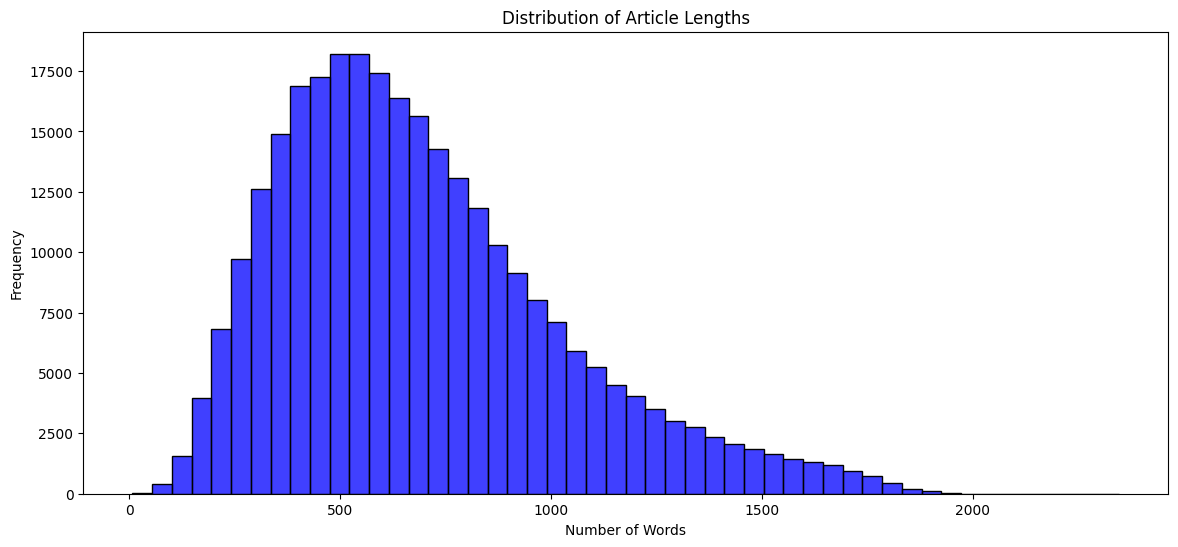

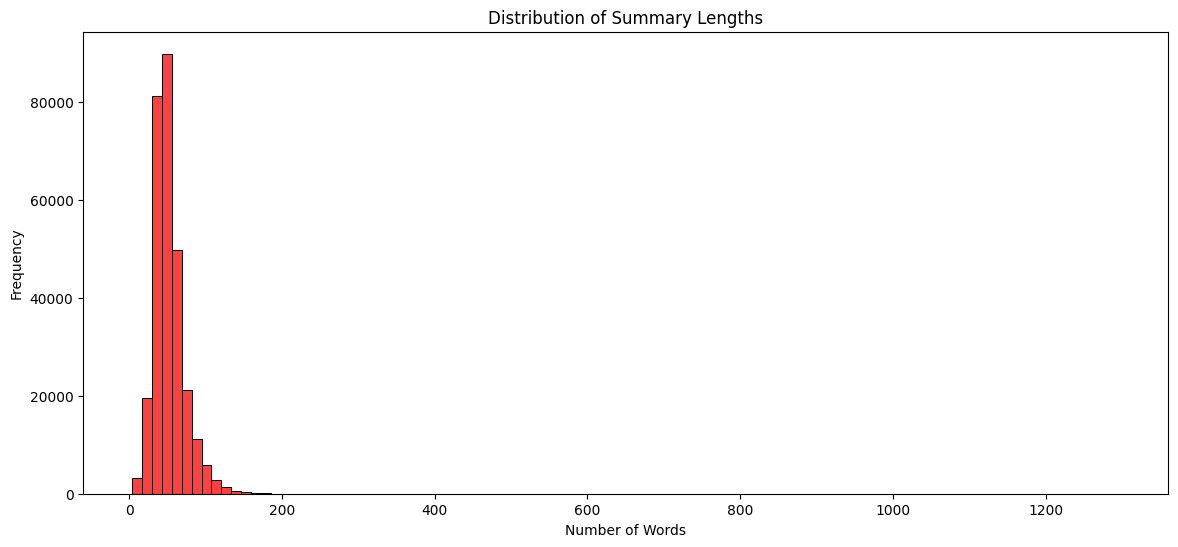

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


# Compute lengths
article_lengths = [len(article.split()) for article in dataset['train']['article']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['highlights']]

# Plotting Article Lengths
plt.figure(figsize=(14, 6))
sns.histplot(article_lengths, bins=50, color='blue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Plotting Summary Lengths
plt.figure(figsize=(14, 6))
sns.histplot(summary_lengths, bins=100, color='red')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

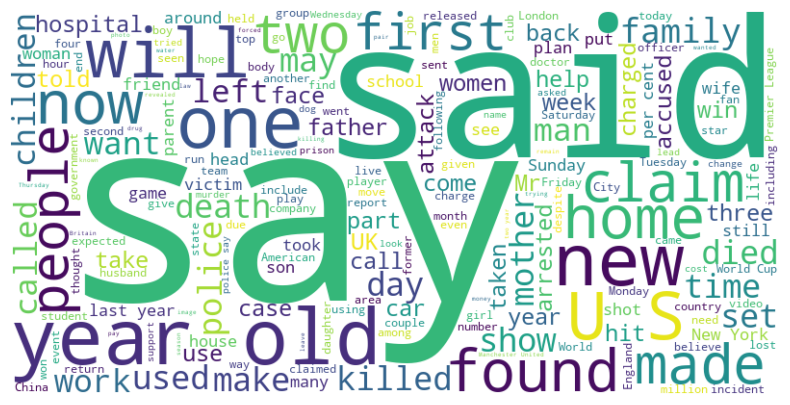

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all summaries
text = " ".join(summary for summary in dataset['train']['highlights'])

# Optionally, you can clean the text (remove stopwords, punctuation, etc.)
# For example:
# text = clean_text_function(text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Disable axis
plt.show()


In [4]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained('lucadiliello/bart-small')
model = BartForConditionalGeneration.from_pretrained('lucadiliello/bart-small')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


In [5]:
def preprocess_function(examples):
    # Tokenize articles and highlights
    inputs = tokenizer(examples['article'], padding='max_length', truncation=True, max_length=512)  # Adjusted max_length
    labels = tokenizer(examples['highlights'], padding='max_length', truncation=True, max_length=150)  # Adjusted max_length

    # Ensure that labels are padded to the same length as inputs
    inputs['labels'] = labels['input_ids']
    return inputs

# Apply the preprocessing function to the dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using device: cuda


In [7]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)

In [8]:
print(device)

cuda:0


In [9]:
import torch
print(torch.cuda.is_available())

True


In [10]:
from transformers import Trainer, TrainingArguments


# Define training arguments
training_args = TrainingArguments(  
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',
    report_to="none",
    remove_unused_columns=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model.to('cuda:0'),
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

In [11]:
# Start training
trainer.train()

  0%|          | 0/215337 [00:00<?, ?it/s]

{'loss': 1.5596, 'grad_norm': 3.9659838676452637, 'learning_rate': 5e-05, 'epoch': 0.01}


c:\Users\vishn\OneDrive\Desktop\GUI\creategui\Lib\site-packages\transformers\modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'loss': 1.2285, 'grad_norm': 4.378027439117432, 'learning_rate': 4.988363270758761e-05, 'epoch': 0.01}
{'loss': 1.1817, 'grad_norm': 5.032491207122803, 'learning_rate': 4.976726541517523e-05, 'epoch': 0.02}
{'loss': 1.1971, 'grad_norm': 4.204018592834473, 'learning_rate': 4.965089812276284e-05, 'epoch': 0.03}
{'loss': 1.1906, 'grad_norm': 4.785622596740723, 'learning_rate': 4.953453083035046e-05, 'epoch': 0.03}
{'loss': 1.1881, 'grad_norm': 3.6263225078582764, 'learning_rate': 4.941816353793807e-05, 'epoch': 0.04}
{'loss': 1.2059, 'grad_norm': 4.89120626449585, 'learning_rate': 4.930179624552568e-05, 'epoch': 0.05}
{'loss': 1.1767, 'grad_norm': 4.309548377990723, 'learning_rate': 4.9185428953113295e-05, 'epoch': 0.06}
{'loss': 1.1989, 'grad_norm': 4.351198673248291, 'learning_rate': 4.9069061660700906e-05, 'epoch': 0.06}
{'loss': 1.1711, 'grad_norm': 4.552750110626221, 'learning_rate': 4.895269436828852e-05, 'epoch': 0.07}
{'loss': 1.1641, 'grad_norm': 4.281253814697266, 'learning_rat

KeyboardInterrupt: 

In [ ]:
print(model.config.vocab_size)

50264


In [34]:

# Tokenize a sample input
inputs = tokenizer("Hello, how are you?", return_tensors="pt")
print("Input IDs:", inputs['input_ids'])

# Check token IDs range
vocab_size = tokenizer.vocab_size
print("Vocab Size:", vocab_size)
if (inputs['input_ids'] >= vocab_size).any():
    raise ValueError("Some token IDs are out of range")

Input IDs: tensor([[    0, 31414,     6,   141,    32,    47,   116,     2]])
Vocab Size: 50265
